In [33]:
# Actualizamos los módulos automáticamente
%reload_ext autoreload
%autoreload 2

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Añadir el directorio scripts al PYTHONPATH
sys.path.append(os.path.abspath("../scripts"))

# Importamos funciones personalizadas
import funciones

# Rutas
ruta_steam_games = '../data/steam_games.parquet'

# Carga de datos
steam_games_df = pd.read_parquet(ruta_steam_games)

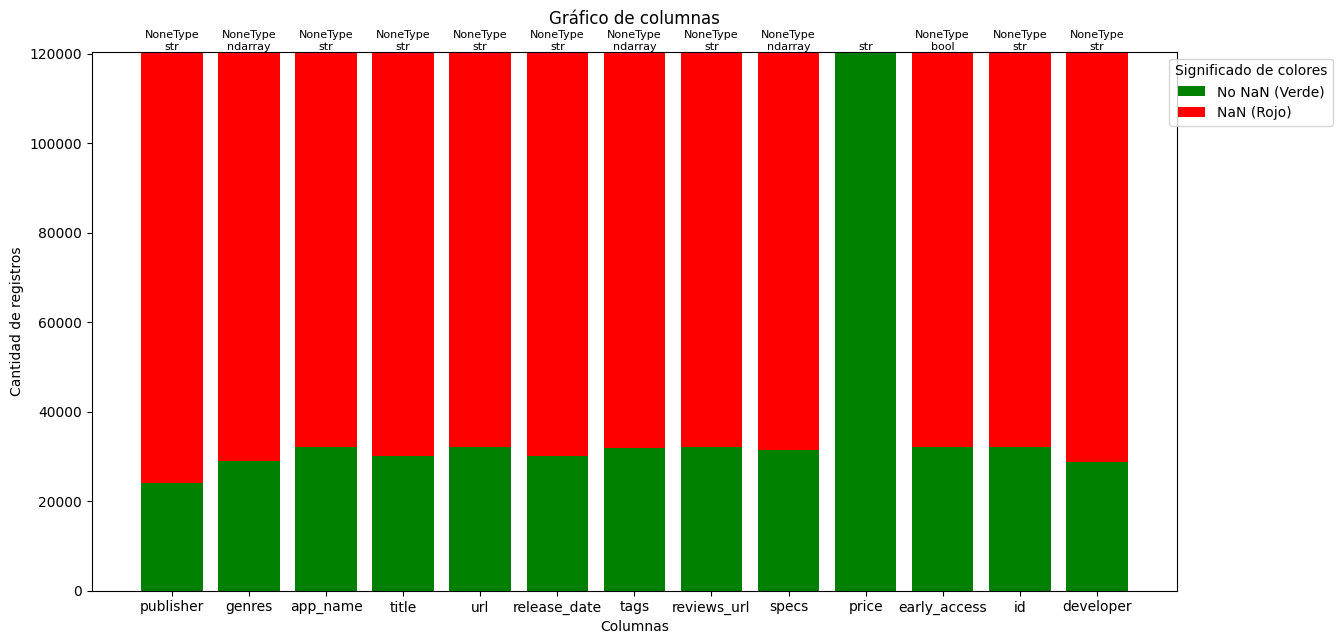

In [34]:
# Primer visualización
funciones.plot_df_info(steam_games_df)

In [35]:
# filtramos columnas que no utilizaremos
steam_games_df = steam_games_df[['id', 'app_name', 'tags', 'genres', 'release_date', 'developer']]

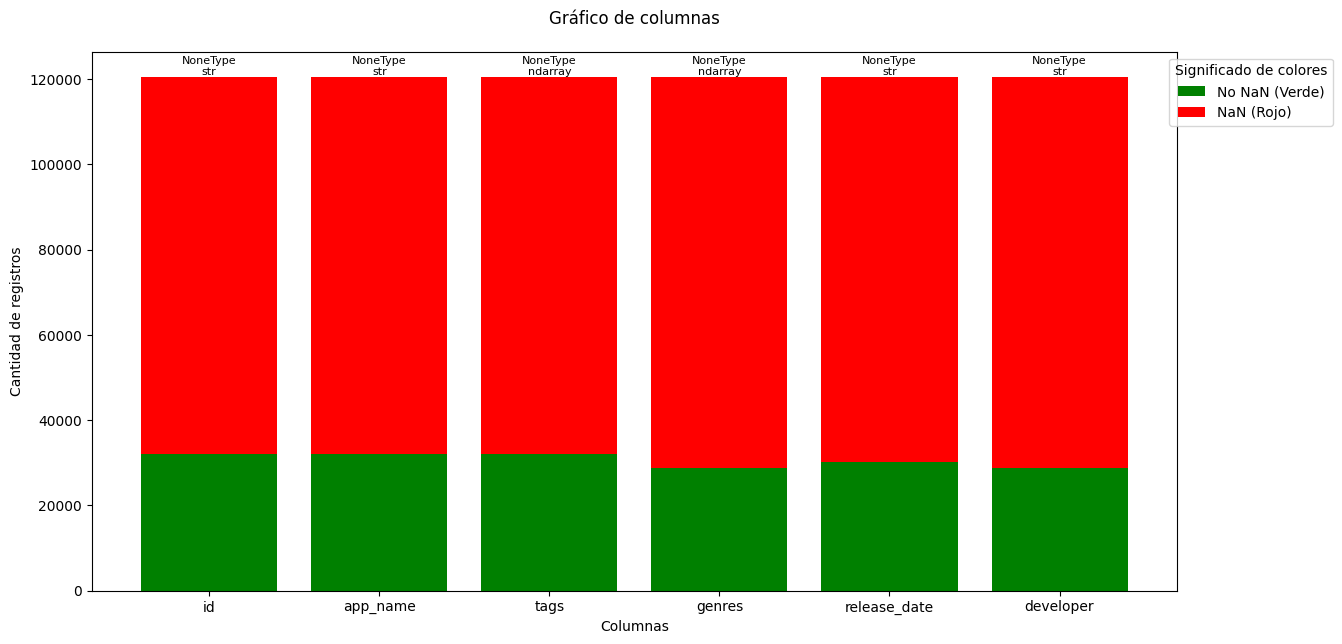

In [36]:
funciones.plot_df_info(steam_games_df)

In [37]:
# pasamos los valores vacios a NaN
steam_games_df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

In [38]:
# rellenamos todos los valores nulos en el dataFrame con NaN
steam_games_df.fillna(pd.NA, inplace=True)

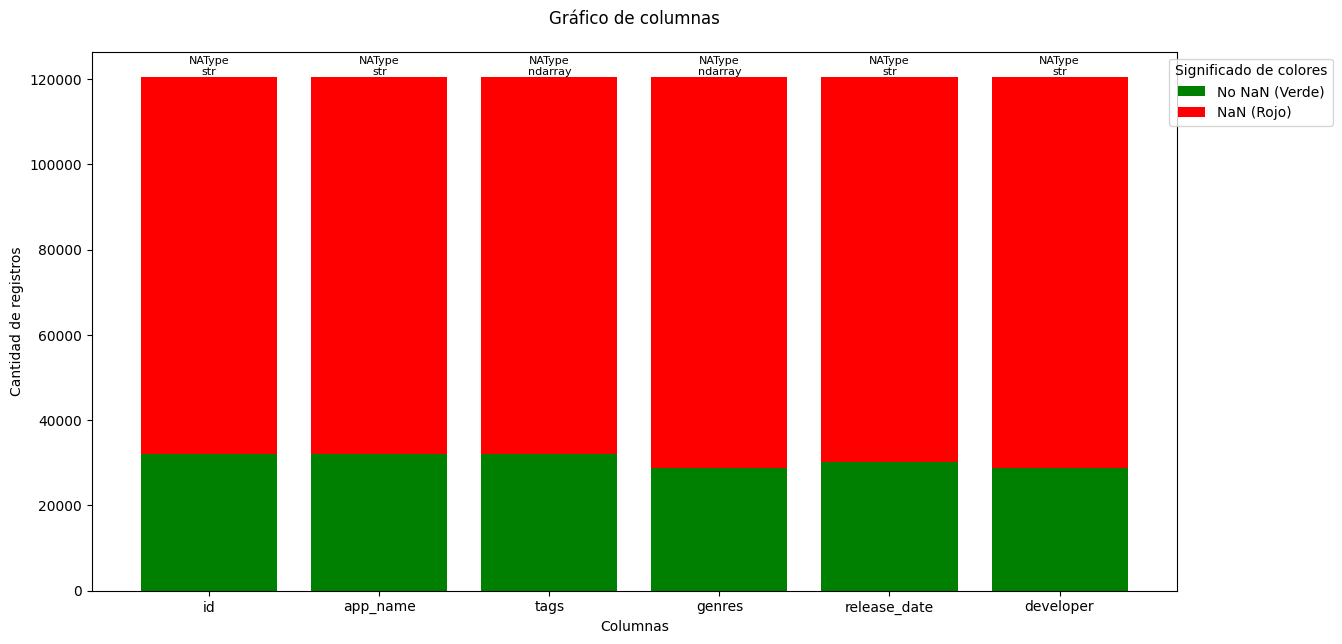

In [39]:
funciones.plot_df_info(steam_games_df)

In [40]:
# Dropeamos las filas que sean todas nulas
steam_games_df = steam_games_df.dropna(how='all')

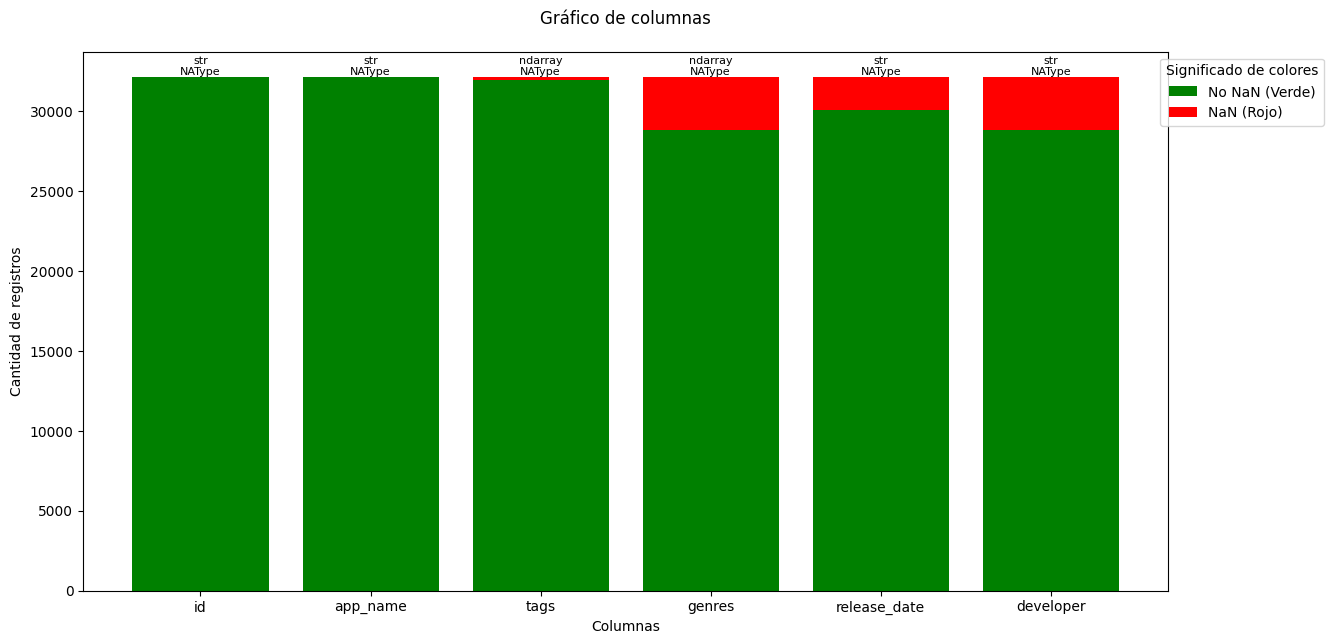

In [41]:
funciones.plot_df_info(steam_games_df)

In [42]:
# tratamos columna por columna, de izquierda a derecha, haciendo un rename de ser necesario, y un paso a tipo de dato especifico

# steam_games.id

# renombramos la columna id como item_id
steam_games_df = steam_games_df.rename(columns={'id': 'item_id'})

# pasamos a tipo de dato numerico
steam_games_df['item_id'] = steam_games_df['item_id'].astype(int, errors='raise')


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NAType'

In [43]:
# al dar error porque no puede convertir un NAType a int, buscamos todos los NATypes de esa columna, y solo obtenemos uno
nan_rows = steam_games_df[steam_games_df['item_id'].isna()]
nan_rows

,item_id,app_name,tags,genres,release_date,developer
119271,<NA>,Batman: Arkham City - Game of the Year Edition,"[Action, Open World, Batman, Adventure, Stealt...","[Action, Adventure]",2012-09-07,"Rocksteady Studios,Feral Interactive (Mac)"


In [44]:
# y aca, filtrando por app name nos damos cuenta que es un duplicado, por lo cual, procedemos a eliminarlo
mask = steam_games_df[steam_games_df['app_name'] == 'Batman: Arkham City - Game of the Year Edition']
mask

,item_id,app_name,tags,genres,release_date,developer
89378,200260,Batman: Arkham City - Game of the Year Edition,"[Action, Open World, Batman, Adventure, Stealt...","[Action, Adventure]",2012-09-07,"Rocksteady Studios,Feral Interactive (Mac)"
119271,<NA>,Batman: Arkham City - Game of the Year Edition,"[Action, Open World, Batman, Adventure, Stealt...","[Action, Adventure]",2012-09-07,"Rocksteady Studios,Feral Interactive (Mac)"


In [45]:
# eliminamos el registro correspondiente
steam_games_df.drop(119271, inplace=True)

In [46]:
# ahora si, procedemos a pasar a tipo numerico
steam_games_df['item_id'] = steam_games_df['item_id'].astype(int, errors='raise')

In [47]:
# ahora que logramos una columna id procedemos a utilizarla para verificar si hay datos duplicados
duplicates = steam_games_df.duplicated(subset=['item_id'])
steam_games_df[duplicates]

,item_id,app_name,tags,genres,release_date,developer
102883,612880,Wolfenstein II: The New Colossus,"[Action, FPS, Gore, Violent, Alternate History...",[Action],2017-10-26,Machine Games


In [48]:
# al parecer hay un dato duplicado
mask = steam_games_df[steam_games_df['item_id'] == 612880]
mask

,item_id,app_name,tags,genres,release_date,developer
102204,612880,Wolfenstein II: The New Colossus,"[Action, FPS, Gore, Violent, Alternate History...",[Action],2017-10-26,Machine Games
102883,612880,Wolfenstein II: The New Colossus,"[Action, FPS, Gore, Violent, Alternate History...",[Action],2017-10-26,Machine Games


In [49]:
# lo borramos
steam_games_df.drop(102883, inplace=True)

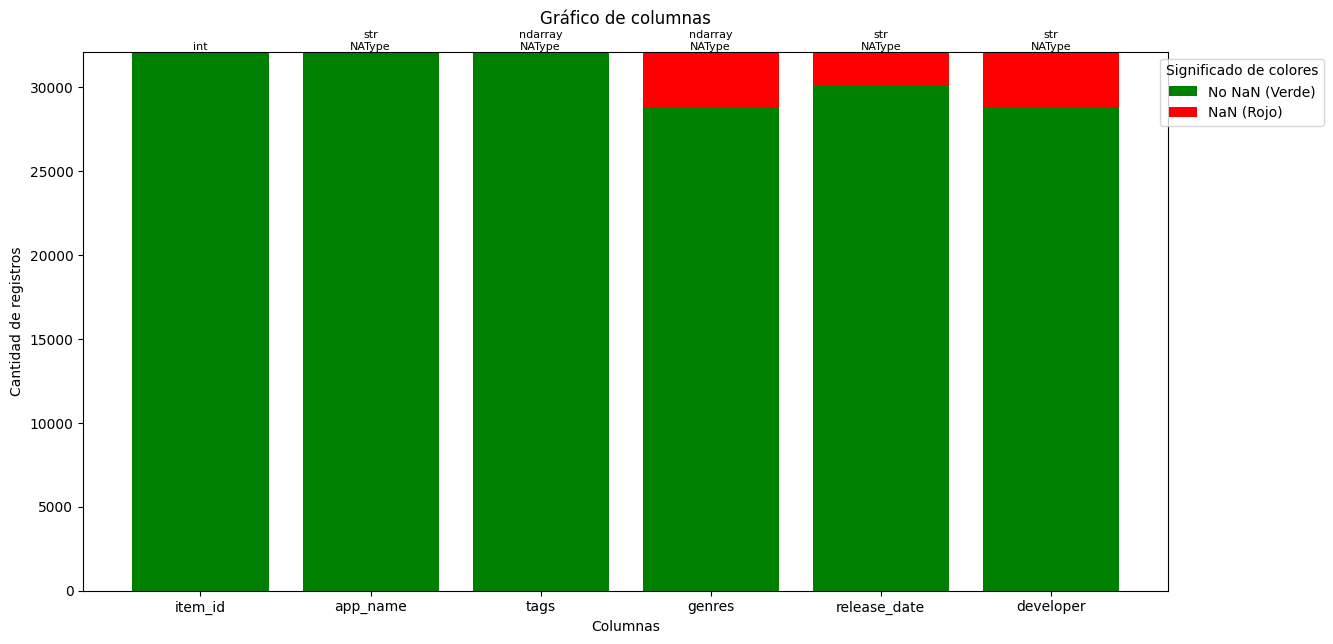

In [50]:
funciones.plot_df_info(steam_games_df)

In [51]:
# Función para convertir todos los datos a ndarray, incluso los NAT, a ndarray's vacios
def convert_to_array(value):
    return np.array(value) if value is not pd.NA else np.array([])

# Aplicar la función a las columnas 'tags' y 'genres'
steam_games_df['tags'] = steam_games_df['tags'].apply(convert_to_array)
steam_games_df['genres'] = steam_games_df['genres'].apply(convert_to_array)


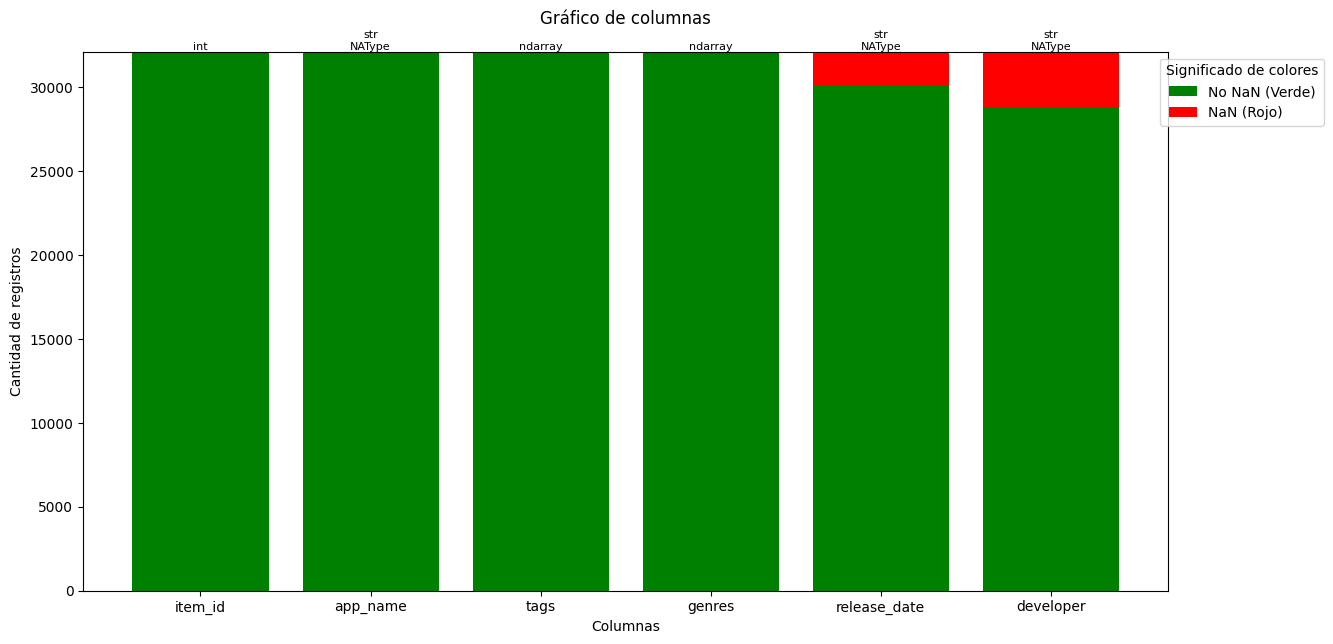

In [52]:
funciones.plot_df_info(steam_games_df)

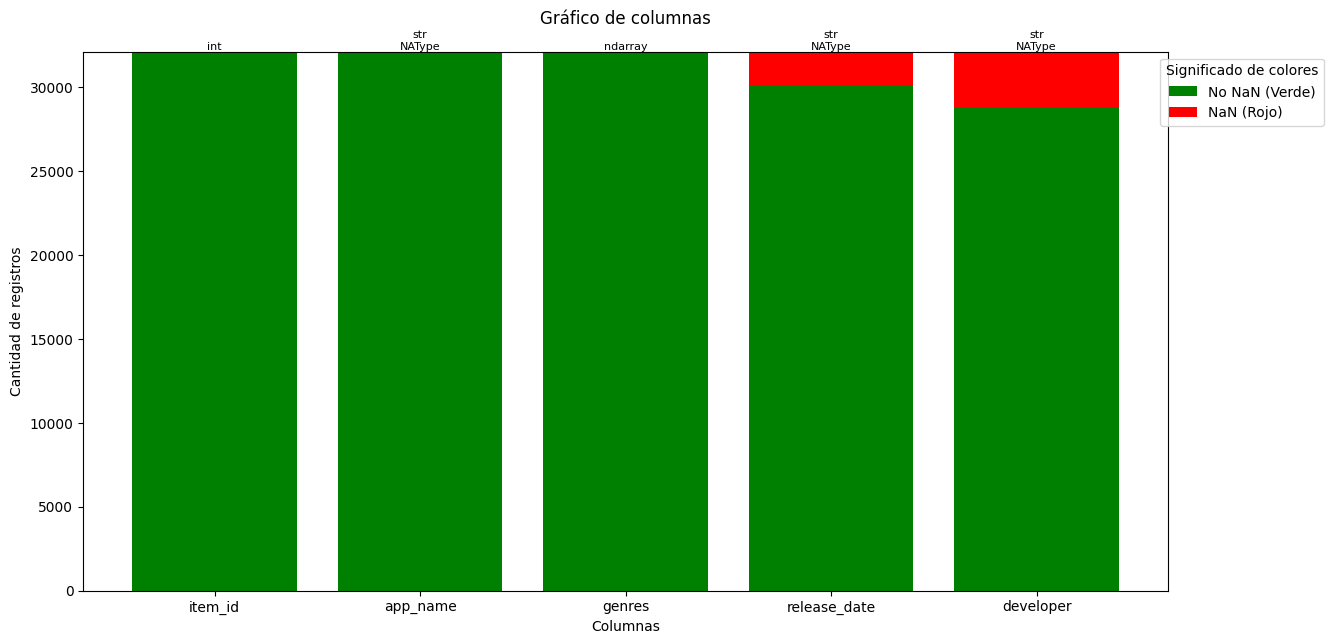

In [53]:
# Función para combinar y quitar duplicados en ndarrays
def combine_and_remove_duplicates(row):
    combined_tags_genres = np.unique(np.concatenate((row['tags'], row['genres']), axis=None))
    return combined_tags_genres


# Aplicar la función para crear la nueva columna
steam_games_df['combined_column'] = steam_games_df.apply(combine_and_remove_duplicates, axis=1)

# Eliminar las columnas 'tags' y 'genres'
steam_games_df = steam_games_df.drop(['tags', 'genres'], axis=1)

# Reorganizar las columnas
steam_games_df = steam_games_df[['item_id', 'app_name', 'combined_column', 'release_date', 'developer']]

# Renombrar la columna 'combined_column' a 'genres'
steam_games_df = steam_games_df.rename(columns={'combined_column': 'genres'})

funciones.plot_df_info(steam_games_df)

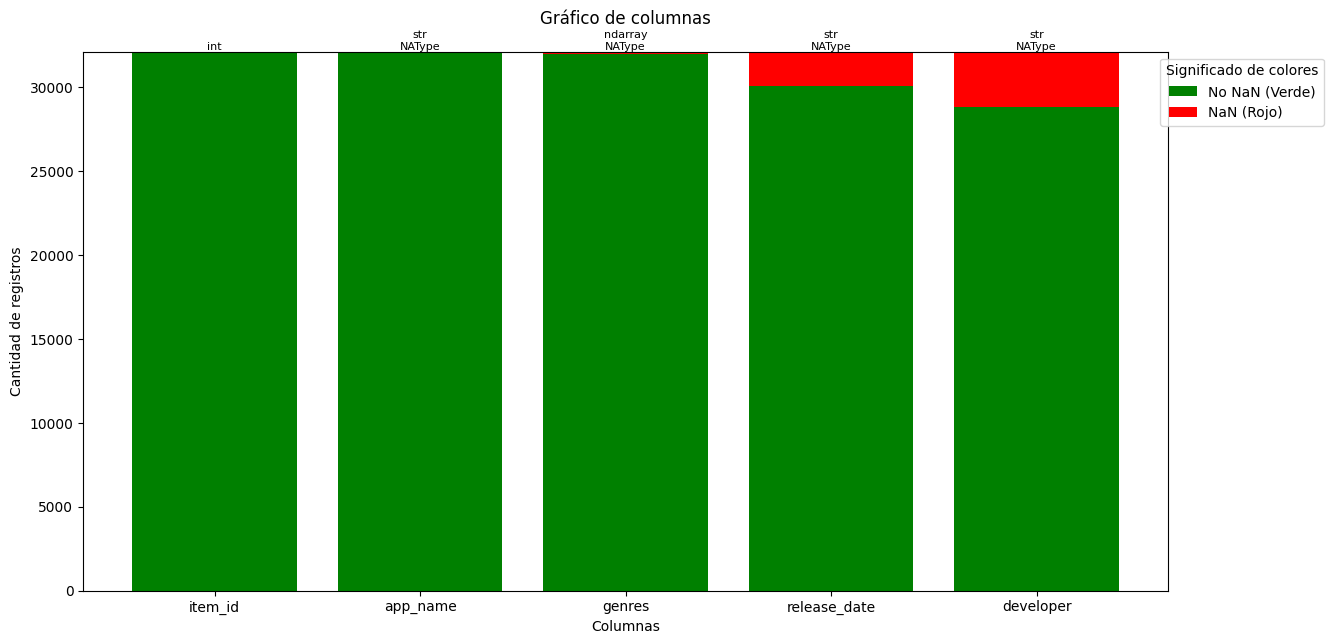

In [54]:
# Reemplazar arrays vacíos por NAType
steam_games_df['genres'] = steam_games_df['genres'].apply(lambda x: x if len(x) > 0 else pd.NA)
funciones.plot_df_info(steam_games_df)

In [56]:
# ver registros nulos
nulos = steam_games_df[steam_games_df['genres'].isna()]
nulos.shape

(138, 5)

In [57]:
# Eliminar registros donde genres y developer sean NaN
steam_games_df = steam_games_df.dropna(subset=['genres', 'developer',], how='all')
nulos = steam_games_df[steam_games_df['genres'].isna()]
nulos.shape

'''
Justificación: debido a que las variables son las unicas con importancia en nuestra API, y son utilizadas de forma aislada
quizás que me falte un dato en una columna pero en la otra no, puedan hacer que no elimine ese registro completo, pero si 
mi registro tiene ambos datos faltantes, y son los unicos que evalúo, el registro en si no me sirve, entonces lo elimino.
'''

'\nJustificación: debido a que las variables son las unicas con importancia en nuestra API, y son utilizadas de forma aislada\nquizás que me falte un dato en una columna pero en la otra no, puedan hacer que no elimine ese registro completo, pero si \nmi registro tiene ambos datos faltantes, y son los unicos que evalúo, el registro en si no me sirve, entonces lo elimino.\n'

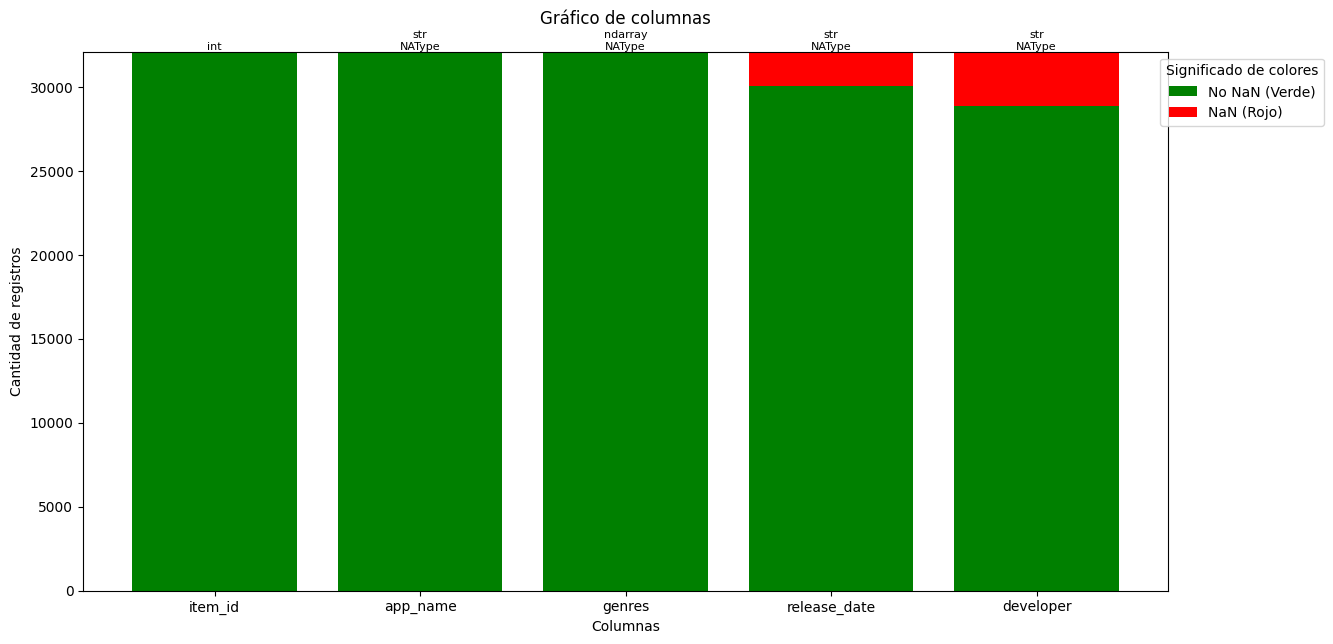

In [58]:
funciones.plot_df_info(steam_games_df)

In [ ]:
'''
Luego de toda esta limpieza, la unica forma de que no haya nulos es recuperando datos, quizas con web scrapping, consultando
alguna API, o sacando conclusiones propias, por ejemplo, si a toda una saga de juegos la hizo el mismo desarrollador pero 
hay un item de ese mismo grupo de videojuegos que tiene en desarrollador 'nulo', podriamos intuir que su desarrollador es el
mismo que el de los otros juegos de su grupo, sin embargo, a fines de acortar los plazos y realizar un MVP, exploraremos esta
posibilidad mas adelante.
'''

"\nLuego de toda esta limpieza, la unica forma de que no haya nulos es recuperando datos, quizas con web scrapping, consultando\nalguna API, o sacando conclusiones propias, por ejemplo, si a toda una saga de juegos la hizo el mismo desarrollador pero \nhay un item de ese mismo grupo de videojuegos que tiene en desarrollador 'nulo', podriamos intuir que su desarrollador es el\nmismo que el de los otros juegos de su grupo, sin embargo, a fines de acortar los plazos y realizar un MVP, exploraremos esta\nposibilidad mas adelante.\n"

In [59]:
# efectuamos los cambios
steam_games_df.to_parquet(ruta_steam_games, index=False)